# Lab 2: Exploring Image Data #

# 1. Business Understanding

### 1.1 Background

Facial recognition is used in a variety of ways within the tech industry. One example is Facebook's automatic tagging. When a user posts a picture of themselves and their friends, Facebook will look at the picture and tag any of the user's friends with their profile. No longer do users have to manually tag their friends on posts. Another use of facial recognition is identifying endangered species in the wild to protect them. With a collection of well-positioned cameras, park rangers and researchers are able to easily monitor wildlife remotely, and the use of facial recognition software allows them to automatically track the locations of endangered species as well as poachers. The popular use of facial modifications through the use of filters such as those found in the popular mobile application *SnapChat* demonstrate that this technology is a useful tool in social media and entertainment industry, as well.

Creating classification models for animal breeds provide a variety of uses. According to the American Humane Society, 10 million household pets are lost every year in the United States. Only a fraction of those pets end up in animal shelters, and many of them won't ever be reunited with their owners. Animal facial recognition technology can help pet owners find their lost pets in conjunction with the numerous public-facing cameras in city streets. Self-driving cars also greatly leverage the use of computer vision technology. Although car manufacturers are more concerened about human lives, animal-related car accidents and fatalities are not uncommon. Being able to identify a large moose on snowy Canadian roads could prevent major car accidents, and the ability to recognize a cat or dog on a road can prevent the loss of someone's pet. The usage of image recognition software is wide-ranging, but we know it is incredibly useful in today's world.

https://americanhumane.org/blog/every-day-is-tag-day-is-your-pet-protected/#:~:text=Each%20year%2C%20approximately%2010%20million,in%20the%20nation's%20animal%20shelters.

https://www.nathab.com/blog/self-driving-vehicles-could-save-animal-lives

### 1.2 Value Proposition

The cat and dog faces dataset is a subset of Cornell University's STARGan v2 dataset of high quality animal faces. These images are useful for solving image-to-image translation problems, where the goal is to learn the mapping between an input image and an output image. A practical application for this would be the use of computer-generated imagery in films and image-editing. Creating software that provides high qualilty, accurate, and fast image-to-image translation using these images can provide great value to the entertainment and other industries.

For our purpose, we are concerned with classifying these images and creating accurate captions. By generating accurate descriptions for these images as either cat or dog, we can help create better tools for animal shelters and wildlife protection organizations for in-depth animal identification tasks.

https://github.com/clovaai/stargan-v2

### 1.3 Measure of Success

Since there exists two different classes in our animal dataset, cat or dog, we expect our predictions to yield a nearly 100% success rate given inputs with the same quality of those within our dataset. The original purpose of the dataset was not image classification so we cannot create a measure of success based on a measure stated within the associated paper. But, as the classification task associated with the dataset will be binary, the classification must, at minimum, be better than coin flips yielding 50% accuracy

# 2. Data Preparation

### 2.1 Data loading

* Each of our `cats` and `dogs` directories contain 2000 images of the said animal respectively (4000 images total)
* For the sake of reducing computational complexity, each of our cat and dog dataset will be contructed from 500 of these images. 
* These images are loaded into their respective dataset containers, which for now will be a list of images
* To expedite our computatation, we will resize our images from 512 x 512 to 128 x 128 pixels

In [3]:
import cv2
import os 
import glob

def get_list_of_imgs(folder_path):
    data_path = os.path.join(folder_path,'*g') 
    files = glob.glob(data_path) 
    list_of_imgs = []
    lim = 500
    i = 0
    for f1 in files:
        if i >= lim: break
        i += 1
        img = cv2.imread(f1)
        img_resized = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_CUBIC)
        # img_resized = cv2.resize(img, dsize = (128, 128))
        list_of_imgs.append(img_resized)
    return list_of_imgs

cat_folder_path = './cats'
dog_folder_path = './dogs'

list_of_cat_imgs = get_list_of_imgs(cat_folder_path)
print(f'Loaded {len(list_of_cat_imgs)} cat images')
list_of_dog_imgs = get_list_of_imgs(dog_folder_path)
print(f'Loaded {len(list_of_dog_imgs)} dog images')

Loaded 500 cat images
Loaded 500 dog images


*   All images in our dataset are grayscaled since
  * Color is not the most prominent distinguishing attribute between a cat and a dog
  * Luminance is more important in distinguisnig visual features of an image
  * Doing so further reduces the computational complexity of our analyses by allowing us to interact with a number representing a pixel instead of a 3-length (for RGB values) or 4-length (for BGBA values) array
* In addition, we now contain all of our images within Numpy arrays instead of Python lists since Numpy arrays
  * Take up less space
  * Are faster in terms of performing mathematical operations on a large number of data, which certainly is the case for us since we are working with image data, which contain large number of elements (at least 1 per every pixel)

In [4]:
import numpy as np

def list_to_numpy_array(img):
    return np.asarray(img, dtype=np.float32)

def grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.144])

def grayscale_imgs(list_of_imgs):
    return list_to_numpy_array([grayscale(img) for img in list_of_imgs])

np_cats = grayscale_imgs(list_of_cat_imgs)
np_dogs = grayscale_imgs(list_of_dog_imgs)

Here, we ensure that all of our images are of the same size (i.e. are of the expected 126 x 128 dimensions)

In [5]:
def get_height(img):
    return len(img)

def get_width(img):
    return len(img[0])

def check_all_imgs_same_dimensions(imgs, animal_type):
    h = get_height(imgs[0])
    w = get_width(imgs[0])
    h_set = set()
    w_set = set()
    for img in imgs:
        h_set.add(get_height(img))
        w_set.add(get_width(img))
    all_heights_are_equal = len(h_set) == 1
    all_widths_are_equal = len(w_set) == 1
    all_same_dimensions = all_heights_are_equal and all_widths_are_equal
    if all_heights_are_equal and all_widths_are_equal:
      print(f'All {animal_type} images have same width and height ({w} x {h})')
    else:
      print(f'All {animal_type} images DO NOT have same width and height ({w} x {h})')

check_all_imgs_same_dimensions(np_cats, 'cat')
check_all_imgs_same_dimensions(np_dogs, 'dog')

All cat images have same width and height (128 x 128)
All dog images have same width and height (128 x 128)


### 2.2 Image visualization

To ensure that our images have been properly grayscaled, that their resizing have not significantly distorted their image quality, and to provide a visual basis from which we will process our images, we print the first 18 images in each of our dataset.

In [6]:
import matplotlib.pyplot as plt

def plot_gallery(images, titles=None, h=128, w=128, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles: plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Gallery of Cats


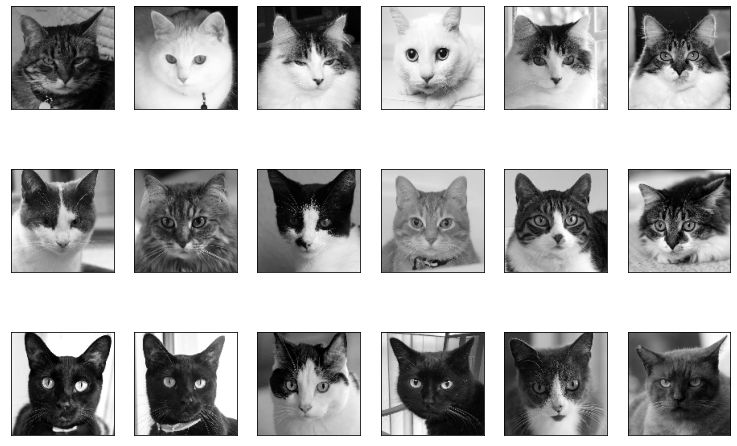

In [7]:
print('Gallery of Cats')
plot_gallery(np_cats)

Gallery of Dogs


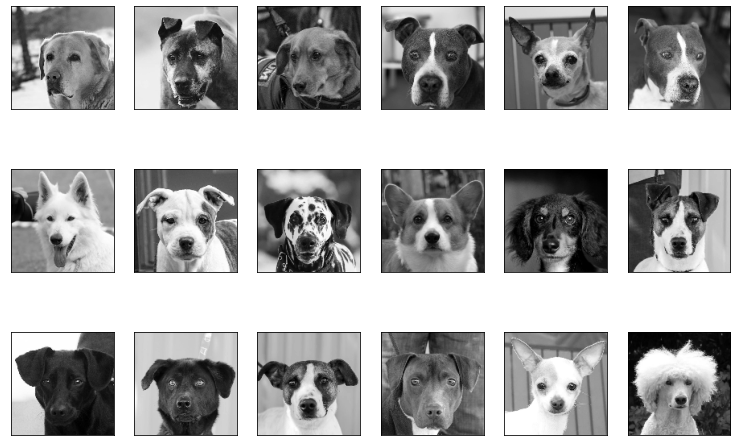

In [8]:
print('Gallery of Dogs')
plot_gallery(np_dogs)

### 2.3 Image linearization

To simplify the procedure of performing statistical analyses on our datasets, we flatten our images, meaning we take the currernt array of arrays data structure of every image (128 x 128) and turn it into a singe array of 16384 (= 128 * 128) pixels.

In [9]:
import pandas as pd
import numpy as np

def flatten(img):
  return img.flatten()

def apply_to_all(imgs, func):
    return list_to_numpy_array([func(img) for img in imgs])

flatten_cats = apply_to_all(np_cats, flatten)
flatten_dogs = apply_to_all(np_dogs, flatten)

df_cat = pd.DataFrame.from_records(flatten_cats)
df_dog = pd.DataFrame.from_records(flatten_dogs)

In [11]:
df_cat.head()

0           1           2           3           4           5      \
0  134.475998  129.326004  133.445999  137.565994  147.865997  151.985992   
1   75.599998   77.660004   77.660004   80.750000   81.779999   86.930000   
2   23.291000   23.291000   30.500999   28.441000   28.441000   28.441000   
3  213.210007  215.270004  215.270004  217.330002  217.330002  217.330002   
4  181.667999  181.667999  180.638000  183.727997  186.541000  206.554001   

        6           7           8           9      ...       16374  \
0  153.016006  154.046005  151.985992  149.925995  ...   39.084999   
1   79.720001   85.900002   76.486000   86.786003  ...   47.236000   
2   28.441000   27.410999   24.930000   21.840000  ...  161.266998   
3  218.360001  218.360001  219.235001  218.360001  ...  241.186005   
4  224.972000  202.921005  234.973007  223.056000  ...  198.557999   

        16375       16376       16377       16378       16379       16380  \
0   35.098000   23.025999   43.914001   60.826000   46.694000   32.273998   
1   47.236000   49.429001   45.608002   49.728001   76.508003   47.236000   
2  130.367004  156.559998  145.229996   80.339996   88.580002   74.758003   
3  241.186005  240.466003  240.466003  244.287003  244.287003  242.227005   
4  200.628998  197.251007  219.944000  194.050003  192.100998  176.906006   

        16381       16382       16383  
0   44.932999   43.914001   37.445999  
1   47.236000   45.175999   45.175999  
2   24.288000   96.388000   23.257999  
3  242.227005  245.317001  242.227005  
4  169.253006  169.098007  167.037994  

[5 rows x 16384 columns]

In [13]:
df_dog.head()

0           1           2           3           4           5      \
0  245.429001  249.438004  251.664001  248.707001  241.873993  227.908997   
1  211.151993  211.151993  211.151993  211.151993  211.162994  211.162994   
2   87.872002   83.763000   85.102997   83.197998   85.279999   82.190002   
3  201.281998  201.281998  200.251999  202.311996  203.341995  204.371994   
4  213.242996  213.242996  213.242996  213.242996  213.242996  213.242996   

        6           7           8           9      ...       16374  \
0  198.914993   82.700996   67.915001   69.997002  ...  170.240997   
1  212.192993  212.192993  212.059998  212.059998  ...   74.724998   
2   94.550003   89.543999   93.973999   72.653999  ...   15.362000   
3  204.371994  208.492004  214.240005  219.389999  ...   40.557999   
4  214.272995  214.272995  214.561005  214.561005  ...  148.233002   

        16375       16376       16377       16378       16379       16380  \
0  127.755997  140.093994  118.597000  131.089996  118.574997  124.290001   
1   77.936996   85.258003   89.832001   83.961998   84.416000   82.943001   
2   45.188000   43.859001   28.863001   25.018999   33.877998   59.771000   
3   40.557999   43.471001   43.471001   43.471001   46.561001   50.980000   
4  146.173004  147.501999  150.735992  150.425995  143.936005  145.729996   

        16381       16382       16383  
0  114.566002  126.760002  128.964005  
1   72.942001   69.574997   77.825996  
2   57.423000   56.237999   42.814999  
3   47.889999   50.980000   52.009998  
4  147.192001  143.503998  137.014008  

[5 rows x 16384 columns]

# 3. Data Reduction

### 3.1 Dimensionality Reduction with Principle Component Analysis Linear

In [14]:
# Reference: https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb ln 35
from sklearn.decomposition import PCA

animals = ['cat', 'dog']
np_animals = np.concatenate((np_cats, np_dogs), axis=0)
animal_data = np.concatenate((flatten_cats, flatten_dogs), axis=0)

X = animal_data
Y = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

n_samples, n_features = X.shape
_, h, w = np_animals.shape
n_classes = len(animals)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))

n_samples: 1000
n_features: 16384
n_classes: 2
Original Image Sizes 128 by 128


In [30]:
def pca_fit(is_pca=True):
  n_components = 300
  print ("Extracting the top %d eigenfaces from %d faces" % (
      n_components, X.shape[0]))

  pca = PCA(n_components=n_components, svd_solver='full' if is_pca else 'randomized')
  %time pca.fit(X.copy())
  eigenfaces = pca.components_.reshape((n_components, h, w))
  return (pca, eigenfaces)

pca,eigenfaces = pca_fit()

Extracting the top 300 eigenfaces from 1000 faces
CPU times: user 19.4 s, sys: 9.67 s, total: 29.1 s
Wall time: 3.9 s


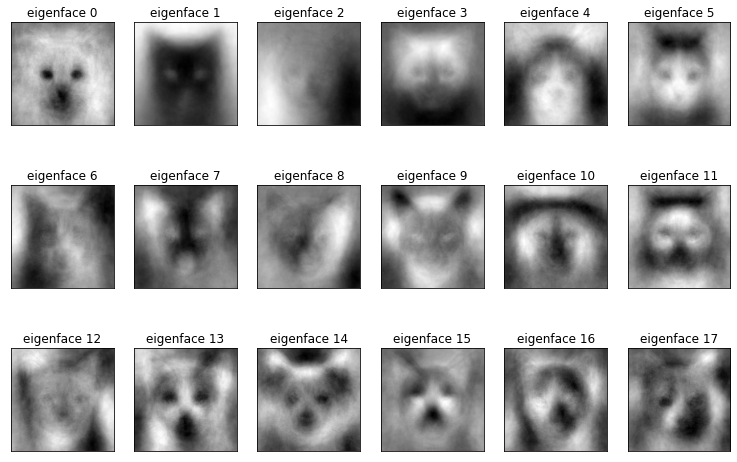

In [31]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

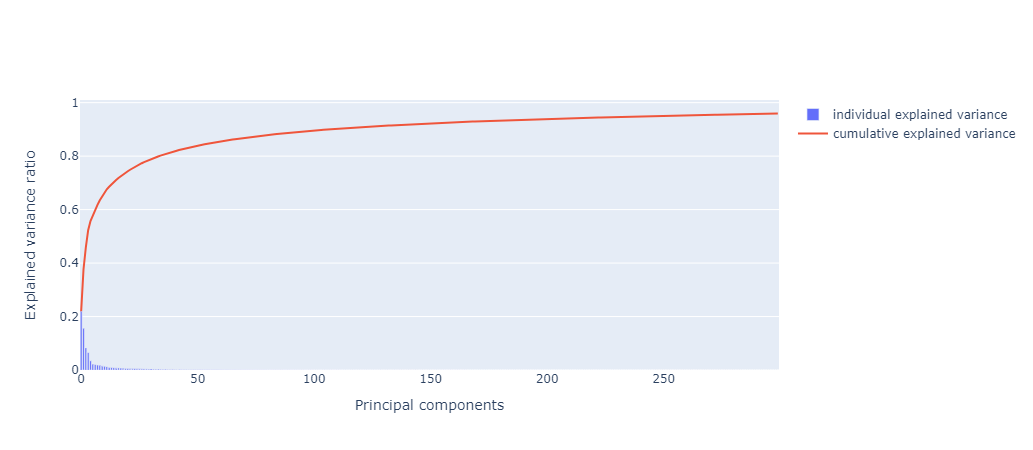

In [32]:
# Reference: https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb ln 8
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
        })

plot_explained_variance(pca)

### 3.2 Dimensionality Reduction with Randomized Principle Component Analysis Linear

In [33]:
rpca, eigenfaces = pca_fit(False)

Extracting the top 300 eigenfaces from 1000 faces
CPU times: user 9.89 s, sys: 11.6 s, total: 21.5 s
Wall time: 2.15 s


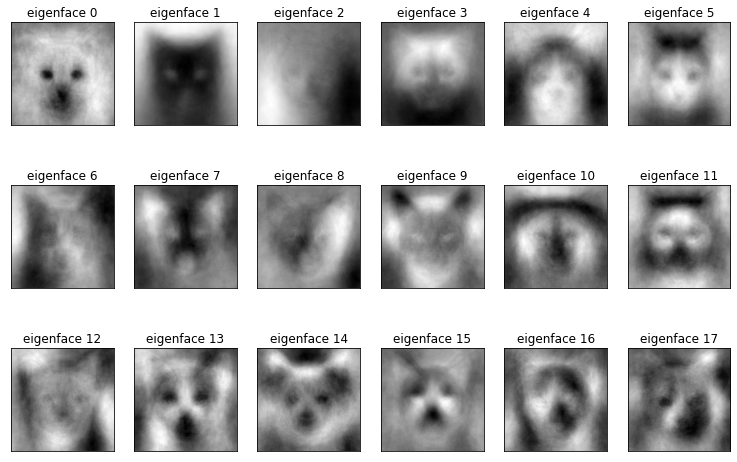

In [34]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

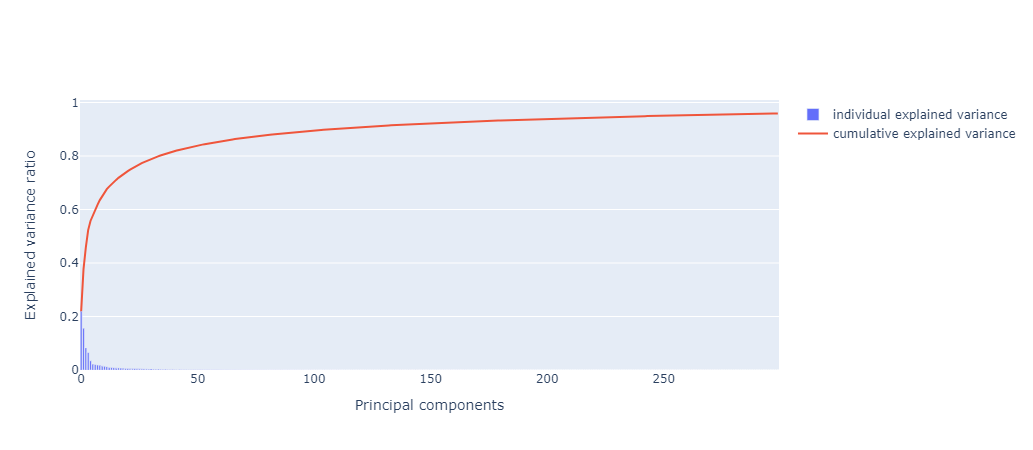

In [36]:
plot_explained_variance(rpca)

### 3.3 PCA vs Random PCA

In [35]:

from ipywidgets import widgets
import warnings

def plt_reconstruct(idx_to_reconstruct):
    # this code is for reference only, it does not qualify as a neaarest neighbor search
    #  for your lab project. 
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    x_flat = X[idx_to_reconstruct].reshape(1, -1)
    reconstructed_image = pca.inverse_transform(pca.transform(x_flat.copy()))    
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(x_flat.copy()))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,3,1) # original
    plt.imshow(x_flat.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid(False)
    
    plt.subplot(1,3,2) # pca
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid(False)
    
    plt.subplot(1,3,3) # randomized pca
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid(False)
    
    
print('Original photos and reconstructed images with PCA and RPCA')
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)
plt.show()

Original photos and reconstructed images with PCA and RPCA


interactive(children=(IntSlider(value=499, description='idx_to_reconstruct', max=999), Output()), _dom_classes…

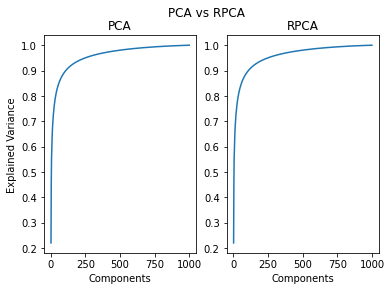

In [38]:
def reduction_analysis(is_pca=True, max_components=1000, threshhold=.95):
    components = []
    explained_variance_ratio = []
    sum_variance = 0
    n_threshhold = 0
    
    pca = PCA(n_components=max_components, svd_solver='full' if is_pca else 'randomized')
    pca.fit(X.copy())
    for i in range(1, max_components + 1):
        components.append(i)
        sum_variance += pca.explained_variance_ratio_[i-1]
        explained_variance_ratio.append(sum_variance)
        if n_threshhold == 0 and sum_variance > threshhold:
            n_threshhold = i
    
    return {'components':components, 'explained_variance_ratio':explained_variance_ratio, 'n_threshhold':n_threshhold}

pca_plot = reduction_analysis()
rpca_plot = reduction_analysis(is_pca=False)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('PCA vs RPCA')
ax1.set_title('PCA')
ax1.set_xlabel('Components')
ax1.set_ylabel('Explained Variance')

ax2.set_title('RPCA')
ax2.set_xlabel('Components')

ax1.plot(pca_plot['components'], pca_plot['explained_variance_ratio'])
ax2.plot(rpca_plot['components'], rpca_plot['explained_variance_ratio'])
plt.show()

By plotting the total explained variance and the number of components for both PCA and RPCA, we can see that the lines are extremely similar. This led us to believe there was a problem with our implementation, that the curves actually **were** identical. But, they are not

In [39]:
print(f"Are the graphs identical? {pca_plot['explained_variance_ratio'] == rpca_plot['explained_variance_ratio']}")
print(f"Sum of all differences in explained variance: {sum(np.asarray(pca_plot['explained_variance_ratio']) - rpca_plot['explained_variance_ratio'])}")
print(f"Number of componends for PCA to reach .95 explained variance: {pca_plot['n_threshhold']}")
print(f"Number of componends for RCA to reach .95 explained variance: {rpca_plot['n_threshhold']}")

Are the graphs identical? False
Sum of all differences in explained variance: -0.0001955311113832625
Number of componends for PCA to reach .95 explained variance: 248
Number of componends for RCA to reach .95 explained variance: 248


We can see from the validation procedure that the curves are indeed different, but only by a very small margin. For out purposes, there is practically no difference in the resulting curves. This is enhanced by the fact that to reach a threshold of 95% of explained variance, each method must use the same number of components. We can safely say that the effectiveness for the two methods for linearly reducing the images are the same. Although full PCA produces the most optimal results for image reduction, the execution time is much larger than randomized PCA. Since the difference in execution results is minimal, time becomes a much alrger factor when consid

# 4. Feature Extractions and Model Buildings

### 4.1 Basic statistics

* To explore our newly created dataframes, we will examine the mean, standard deviation, skew, and kurosis of our cat and dog dataframes. 
  * The purpose of this analysis is to see if there are significant differences between these statistics between our dataframes so that if such were to be the case, we may pursue the route of distinguishing our cat and dog images by performing Gabor filter Banks texture classification.
  * This idea initially arose from our impression that since some cats tend to have striped fur and most dogs do not, such distinction may materialize in the form of differences in the mean, standard deviation, skew, and/or kurosis between our respective datasets. Of course, there are cats who do not have any stripes either, so this exploration also serves as a way to affirm or disconfirm our aforementioned impression 

In [40]:
# statistics of pixel values
def generate_df_stat(df):
    df_stat = pd.DataFrame()
    df_stat['mean'] = [df.iloc[i].mean() for i in range(len(df))]
    df_stat['std'] = [df.iloc[i].std() for i in range(len(df))]
    df_stat['skew'] = [df.iloc[i].skew() for i in range(len(df))]
    df_stat['kurtosis'] = [df.iloc[i].kurtosis() for i in range(len(df))]
    return df_stat

In [41]:
df_stat_cat = generate_df_stat(df_cat)
df_stat_dog = generate_df_stat(df_dog)

In [44]:
df_stat_cat.head()

mean        std      skew  kurtosis
0   80.416864  53.004469  0.278737 -1.222867
1  182.343934  67.400800 -0.880999 -0.441023
2  129.940534  84.503456 -0.208835 -1.598691
3  215.094105  41.805446 -2.082587  4.518465
4  173.656769  66.989861 -0.874586 -0.101390

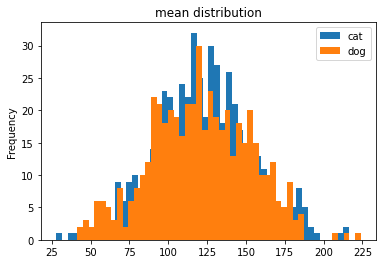

Cat mean stats:
count    500.000000
mean     121.695437
std       30.733438
min       27.839090
25%      102.064749
50%      121.235241
75%      141.209683
max      216.239909
Name: mean, dtype: float64

Dog mean stats:
count    500.000000
mean     120.835311
std       31.907411
min       41.469804
25%       98.751739
50%      120.084363
75%      144.161148
max      223.759450
Name: mean, dtype: float64
-----------------------------------------------


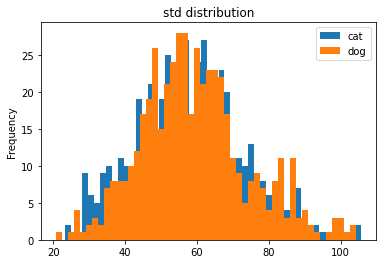

Cat std stats:
count    500.000000
mean      57.453592
std       14.864349
min       23.188789
25%       47.172350
50%       56.822485
75%       66.820546
max      105.510559
Name: std, dtype: float64

Dog std stats:
count    500.000000
mean      59.439958
std       14.945869
min       20.812780
25%       48.681511
50%       58.245155
75%       67.368026
max      104.279501
Name: std, dtype: float64
-----------------------------------------------


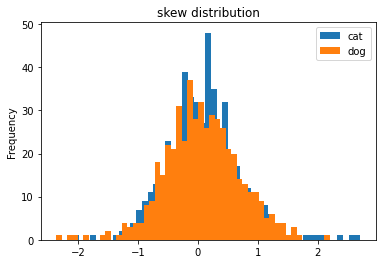

Cat skew stats:
count    500.000000
mean       0.074083
std        0.608283
min       -2.082587
25%       -0.290471
50%        0.069873
75%        0.408453
max        2.710151
Name: skew, dtype: float64

Dog skew stats:
count    500.000000
mean       0.069110
std        0.623583
min       -2.362074
25%       -0.321561
50%        0.051146
75%        0.458684
max        2.197663
Name: skew, dtype: float64
-----------------------------------------------


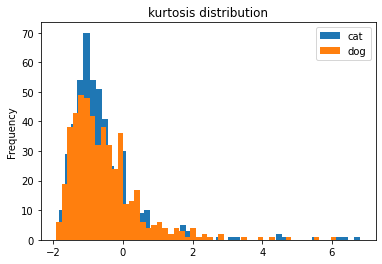

Cat kurtosis stats:
count    500.000000
mean      -0.552783
std        1.058920
min       -1.818891
25%       -1.140131
50%       -0.790636
75%       -0.240659
max        6.817171
Name: kurtosis, dtype: float64

Dog kurtosis stats:
count    500.000000
mean      -0.534338
std        1.026104
min       -1.915221
25%       -1.206986
50%       -0.763856
75%       -0.119786
max        6.120566
Name: kurtosis, dtype: float64
-----------------------------------------------


In [45]:
stat_features = ['mean', 'std', 'skew', 'kurtosis']

for feature in stat_features:
    df_stat_cat[feature].plot(kind='hist', bins=50)
    df_stat_dog[feature].plot(kind='hist', bins=50)
    plt.legend(['cat', 'dog'])
    plt.title(feature + ' distribution')
    plt.show()
    print("Cat", feature, "stats:")
    print(df_stat_cat[feature].describe())
    print()
    print("Dog", feature, "stats:")
    print(df_stat_dog[feature].describe())
    print("-----------------------------------------------")

As seen from these graphs, the differences in mean, skew, and kurtosis between our cat and dog dataframes strengthen the possibility that we could use the texture-related differences between a dog and cat image to classify the two images using Gabor filter Banks approach.

### 4.2 Daisy features and KNN model

In [48]:
# Merging dog and cat dataframe
df_both = pd.concat([df_cat, df_dog], ignore_index=True)
df_both.head()

0           1           2           3           4           5      \
0  134.475998  129.326004  133.445999  137.565994  147.865997  151.985992   
1   75.599998   77.660004   77.660004   80.750000   81.779999   86.930000   
2   23.291000   23.291000   30.500999   28.441000   28.441000   28.441000   
3  213.210007  215.270004  215.270004  217.330002  217.330002  217.330002   
4  181.667999  181.667999  180.638000  183.727997  186.541000  206.554001   

        6           7           8           9      ...       16374  \
0  153.016006  154.046005  151.985992  149.925995  ...   39.084999   
1   79.720001   85.900002   76.486000   86.786003  ...   47.236000   
2   28.441000   27.410999   24.930000   21.840000  ...  161.266998   
3  218.360001  218.360001  219.235001  218.360001  ...  241.186005   
4  224.972000  202.921005  234.973007  223.056000  ...  198.557999   

        16375       16376       16377       16378       16379       16380  \
0   35.098000   23.025999   43.914001   60.826000   46.694000   32.273998   
1   47.236000   49.429001   45.608002   49.728001   76.508003   47.236000   
2  130.367004  156.559998  145.229996   80.339996   88.580002   74.758003   
3  241.186005  240.466003  240.466003  244.287003  244.287003  242.227005   
4  200.628998  197.251007  219.944000  194.050003  192.100998  176.906006   

        16381       16382       16383  
0   44.932999   43.914001   37.445999  
1   47.236000   45.175999   45.175999  
2   24.288000   96.388000   23.257999  
3  242.227005  245.317001  242.227005  
4  169.253006  169.098007  167.037994  

[5 rows x 16384 columns]

In [49]:
from skimage.feature import daisy
h = w = 128
features = daisy(img, step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

ModuleNotFoundError: No module named 'skimage'

In [ ]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
    return feat.reshape((-1))

Now, we are going to try visulize how DAISY works in the dataset by choosing random image and finding the most similar one to it. 

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, df_both, (h,w))
print(daisy_features.shape)

# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)


In [ ]:
import copy
# find closest image to current image, try with 10 images

for _ in range(10):
    idx1 = int(np.random.rand(1)*len(df_both))
    X = df_both.to_numpy()
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    imshow(X[idx1].reshape((h,w)), cmap='gray')
    plt.title("Original Image")
    plt.grid()

    plt.subplot(1,2,2)
    imshow(X[idx2].reshape((h,w)), cmap='gray')
    plt.title("Closest Image")
    plt.grid()
    plt.show()

We can see some dogs are matched with cats. Closest image may not be the best here. Now, let's try to run real prediction with K-th Nearest Neighbor and some different number of neighbors.

In [ ]:
# Split dataset to training and validating
# 0 for cat, 1 for dog
from sklearn.model_selection import train_test_split
train_cat, test_cat = train_test_split(df_cat.to_numpy(), test_size=0.2)
train_dog, test_dog = train_test_split(df_dog.to_numpy(), test_size=0.2)

train_X = np.concatenate((train_cat, train_dog))
test_X = np.concatenate((test_cat, test_dog))
train_y = np.concatenate((np.zeros(len(train_cat)), np.ones(len(train_dog))))
test_y = np.concatenate((np.zeros(len(test_cat)), np.ones(len(test_dog))))
print(len(train_X), len(test_X), len(train_y))
print(len(test_y), test_y)

In [ ]:
# Applying DAISY to testing data
%time daisy_training = np.apply_along_axis(apply_daisy, 1, train_X, (h,w))
print(daisy_training.shape)

In [ ]:
# Training and Testing with multiple number of neighbors
# Reference: Nathan's project
# https://github.com/n-wes/google_earth_image_classification/blob/master/img_analysis.ipynb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

daisy_testing = np.apply_along_axis(apply_daisy, 1, test_X, (h,w))

training_accuracy = []
test_accuracy = []
k_range = range(2,6)
neighbors_settings = k_range

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(daisy_training, train_y)
    # training_accuracy.append(clf.score(daisy_training, train_y))
    test_accuracy.append(clf.score(daisy_testing, test_y))
    print(f"# Neighbors {n_neighbors} - Testing score {test_accuracy[-1]}")

# plt.plot(neighbors_settings, training_accuracy, label="Training Accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Testing Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("K Neighbors")
plt.legend()
plt.xticks(np.arange(min(k_range), max(k_range)+1, 1.0))
plt.show()


### 4.3 Edge detection and Logistic Regression model

To further the effectiveness of our k-nearest neighbors approach, we will pre-process our data by performing edge-detection algorithms on the images in our datasets before turning them into a dataframe to apply our k-nearest neighbors analysis. 

Since cats and dogs tend to have distinctive profiles (while cats tend to have pointy erect ears, most dogs have floppy ears; cats tend to have shorter snouts than dogs, etc.) and differing fur patterns (more cats tend to have striped fur as previously mentioned), we hope that by performing edge-detection image processing, we can accentuate these differences between cats and dogs before applying k-nearest neighbors.

In [ ]:
from skimage.filters import sobel_h, sobel_v

def sobel(img):
    return np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 )

def show(img, title = ''):
    plt.imshow(img, cmap='gray')
    if len(title): plt.title(title)
    plt.xticks(())
    plt.yticks(())
    plt.show()

Additionally, we perform Gaussian blur to see if the distinguishing features of an image can be further accentuated.

In [ ]:
from skimage.filters import gaussian

def gaussian_blur(img):
    return gaussian(img, sigma=(1, 1), truncate=3.5, multichannel=True)

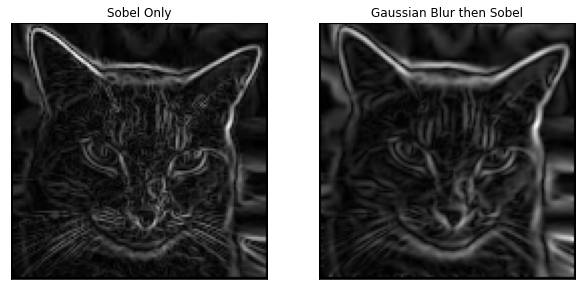

In [ ]:
img1 = np_cat[0]
sobeled_only = sobel(img1)

img2 = np_cat[0]
blurred = gaussian_blur(img2)
burred_then_sobeled = sobel(blurred)

def show_side_by_side(img1, img2, title1 = '', title2 = ''):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap=plt.cm.gray)
    if len(title1): plt.title(title1)
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=plt.cm.gray)
    if len(title2): plt.title(title2)
    plt.xticks(())
    plt.yticks(())

show_side_by_side(sobeled_only, burred_then_sobeled, 'Sobel Only', 'Gaussian Blur then Sobel')

As seen from these photos, although applying Gaussian blur to an image and then performing Sobel edge detection can help reduce the noise of an image, it does not necessarily accentuate the image's distinguishing features, so much so that the reduction in blur that comes from running this algorithm justifies the computational complexity of doing so.

Thus, for the sake of reducing computational complexity of our analysis, we will perform only Sobel edge detection on our images before preparing our datasets for k-nearest neighbors.

In [ ]:
np_sobel_cats = apply_to_all(np_cats, sobel)
np_sobel_dogs = apply_to_all(np_dogs, sobel)

NameError: ignored

In [ ]:
flatten_sobel_cats = apply_to_all(np_sobel_cats, flatten)
flatten_sobel_dogs = apply_to_all(np_sobel_dogs, flatten)

NameError: ignored

In [ ]:
df_sobel_cat = pd.DataFrame.from_records(flatten_sobel_cats)
df_sobel_dog = pd.DataFrame.from_records(flatten_sobel_dogs)

In [ ]:
df_stat_sobel_cat = generate_df_stat(df_sobel_cat)
df_stat_sobel_dog = generate_df_stat(df_sobel_dog)

In [ ]:
df_stat_sobel_cat

In [ ]:
stat_features = ['mean', 'std', 'skew', 'kurtosis']

for feature in stat_features:
    df_stat_sobel_cat[feature].plot(kind='hist', bins=50)
    df_stat_sobel_dog[feature].plot(kind='hist', bins=50)
    plt.legend(['cat', 'dog'])
    plt.title(feature + ' distribution')
    plt.show()
    print("Cat", feature, "stats:")
    print(df_stat_cat[feature].describe())
    print()
    print("Dog", feature, "stats:")
    print(df_stat_dog[feature].describe())
    print("-----------------------------------------------")

In [ ]:
# Combine all stats of original and sobel cat images to a dataframe
df_stat = df_stat_cat.copy()
df_stat['sobel_mean'] = df_stat_sobel_cat['mean']
df_stat['sobel_std'] = df_stat_sobel_cat['std']
df_stat['sobel_skew'] = df_stat_sobel_cat['skew']
df_stat['sobel_kurtosis'] = df_stat_sobel_cat['kurtosis']
df_stat['cat'] = 1

df_stat

In [ ]:
# Combine all stats of original and sobel dog images
df_stat2 = df_stat_dog.copy()
df_stat2['sobel_mean'] = df_stat_sobel_dog['mean']
df_stat2['sobel_std'] = df_stat_sobel_dog['std']
df_stat2['sobel_skew'] = df_stat_sobel_dog['skew']
df_stat2['sobel_kurtosis'] = df_stat_sobel_dog['kurtosis']
df_stat2['cat'] = 0

df_stat2

In [ ]:
# Combine the whole dataset
df_stat = pd.concat([df_stat, df_stat2], ignore_index=True)
df_stat

In [ ]:
y = df_stat['cat'].to_numpy()
del df_stat['cat']
X = df_stat.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
len(y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression().fit(X_train, y_train)

y_hat = reg.predict(X_test)
        
print(f"Testing score using logistic regression {accuracy_score(y_hat, y_test)}")

### 4.4 Sobel, Daisy, and KNN

In this model, we will do sobel filter on images first. Then we apply DAISY operation to them. And finally, using KNN to predict.

In [ ]:
# Merging dog and cat dataframe
df_sobel_both = pd.concat([df_sobel_cat, df_sobel_dog], ignore_index=True)
df_sobel_both

In [ ]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, df_sobel_both, (h,w))
print(daisy_features.shape)

# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)


In [ ]:
import copy
# find closest image to current image, try with 10 images

for _ in range(10):
    idx1 = int(np.random.rand(1)*len(df_both))
    X = df_sobel_both.to_numpy()
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    plt.imshow(X[idx1].reshape((h,w)), cmap='gray')
    plt.title("Original Image")
    plt.grid()

    plt.subplot(1,2,2)
    plt.imshow(X[idx2].reshape((h,w)), cmap='gray')
    plt.title("Closest Image")
    plt.grid()
    plt.show()

In [ ]:
# Split dataset to training and validating
# 0 for cat, 1 for dog
from sklearn.model_selection import train_test_split
train_cat, test_cat = train_test_split(df_sobel_cat.to_numpy(), test_size=0.2)
train_dog, test_dog = train_test_split(df_sobel_dog.to_numpy(), test_size=0.2)

train_X = np.concatenate((train_cat, train_dog))
test_X = np.concatenate((test_cat, test_dog))
train_y = np.concatenate((np.zeros(len(train_cat)), np.ones(len(train_dog))))
test_y = np.concatenate((np.zeros(len(test_cat)), np.ones(len(test_dog))))
print(len(train_X), len(test_X), len(train_y), len(test_y))


In [ ]:
# Applying DAISY to testing data
%time daisy_training = np.apply_along_axis(apply_daisy, 1, train_X, (h,w))
print(daisy_training.shape)

In [ ]:
# Training and Testing with multiple number of neighbors
# Reference: Nathan's project
# https://github.com/n-wes/google_earth_image_classification/blob/master/img_analysis.ipynb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

daisy_testing = np.apply_along_axis(apply_daisy, 1, test_X, (h,w))

training_accuracy = []
test_accuracy = []
k_range = range(2, 6)
neighbors_settings = k_range

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(daisy_training, train_y)
#     training_accuracy.append(clf.score(daisy_training, train_y))
    test_accuracy.append(clf.score(daisy_testing, test_y))
    print(f"# Neighbors {n_neighbors} - Testing score {test_accuracy[-1]}")

# plt.plot(neighbors_settings, training_accuracy, label="Training Accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Testing Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("K Neighbors")
plt.legend()
plt.xticks(np.arange(min(k_range), max(k_range)+1, 1.0))
plt.show()
